# Diffusion+Forcing in 2D
***Shaunticlair Ruiz (based on document by Ian Fenty)***
***2024-7-8***


This notebook builds on the previous Diffusion notebook, and introduces Atmospheric Forcing.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as scipy
import helper


We borrow the following functionality from the previous notebook, saved in the helper.py file:

- ```plot_2d_heatmap_time_evolution(saved_timesteps, state_over_time, nr, nc)```

-------
# 2D Spatially-Variant Forcing + Spatially-Variant Diffusion
-------

### Framing 2D Spatially-Variant Forcing 

Now, we introduce some external **forcing**: in an atmospheric model, this could represent the heat from the atmosphere. 

The transfer between the atmosphere and the ocean is assumed to be proportional to the difference between their concentrations.

- Notably, we assume the atmosphere is *fixed*: the forcing concentration doesn't change, regardless of the ocean state.

We'll represent the atmospheric concentration at cell $(i,j)$ as $f_{ij}$.

- As mentioned, the change in $c_{(ij)}$ is proportional to the difference from $f_{ij}$: it's a sort of "first-order damping".

Our equation for concentration change, *only* due to the atmosphere, can be written as

$$ \frac{\partial c^{force}_{ij}}{\partial t} \propto (f_{ij} - c_{ij}) $$

We'll represent the rate of damping with a constant $F$.

$$ \frac{\partial c^{force}_{ij}}{\partial t} = F (f_{ij} - c_{ij}) $$

If we integrate this into our diffusion PDE, we get:

$$ \frac{\partial c_{ij}}{\partial t} = \frac{\partial^2 c_{ij}}{\partial x^2} + F (f_{ij} - c_{ij}) $$

### Integrating 2D Spatially-Variant Forcing and Diffusion

Introducing this to our pre-existing model is as easy as adding it to the end of our equation:

$$\begin{align*} 
c(t+1) \approx M c(t) +F (f - c(t))
\end{align*}$$

We can integrate this term into our equation:

$$\begin{align*} 
c_{ij}(t+1) \approx & \Big( 1 - \beta_{ij}(T_{(i+1,j)}  + T_{ij}  + S_{(i,j+1)} + S_{ij}) - F \Big) \cdot c_{ij}(t) \\
&+\Big( T_{(i+1,j)}\beta_{ij} \Big) c_{(i+1,j)} +\Big( T_{ij}\beta_{ij} \Big) \cdot   c_{(i-1,j)}(t) \\
&+\Big( S_{(i,j+1)}\beta_{ij} \Big) c_{(i,j+1)}+\Big( S_{ij}\beta_{ij} \Big) \cdot  c_{(i,j-1)}(t) \\
&+F f_{ij}
\end{align*}$$

But now, our equation isn't linear anymore! It's **affine**: we add a constant term $Ff$ on the end.

$$c(t+1) \approx M_f c(t) + Ff $$



### Simulation of 2D Diffusion + Forcing

In [2]:
# nr: number of tracer rows 
# nc: number of tracer columns
# dt: time step

# KX: diffusivity matrix in x direction.  dimension is nr x nc+1
#     defined on 'west' and 'east' edges of all cells
#     [0,0] index is the diffusivity across the 'west' side of southwesternmost grid cell
#     [-1, -1] index is the diffusivity across the 'east' side of the northeasternmost grid cell

# KY: diffusivity matrix in y direction.  dimension is nr+1 x nc
#     defined on 'north' and 'south' edges of all cells
#     [0,0] index is the diffusivity across the 'south' side of southwesternmost grid cell
#     [-1, -1] index is the diffusivity across the 'north' side of the northeasternmost grid cell

# DXC: distance between adjacent grid cell centers in x-direction. dimension is nr x nc+1
#     defined through 'west' and 'east' edges of all cells
#     [0,0] index is the distance between the center of the southwesternmost grid cell the grid cell to its west
#     [-1, -1] index is the distance between the center of the northeasternmost grid cell the grid cell to its east

# DYC: distance between adjacent grid cell centers in y-direction. dimension is nr+1 x nc
#     defined through 'north' and 'south' edges of all cells
#     [0,0] index is the distance between the center of the southwesternmost grid cell the grid cell to its south
#     [-1, -1] index is the distance between the center of the northeasternmost grid cell the grid cell to its north

# DXG: length of the 'south/north' sides of grid cells. dimension nr+1 x nc
#     [0,0] index is the length of the 'south' side of southwesternmost cell
#     [-1,-1] index is the length of the 'north' side of northeasternmost cell

# DYG: length of the 'west/east' sides of grid cells. dimension is nr x nc+1
#     [0,0] index is the length of the 'west' side of southwesternmost cell
#     [-1,-1] index is the length of the 'east' side of northeasternmost cell

# i is row
# j is column

# M[i,j] => ith row, jth column


def make_M_2d_spatially_variant_forced(nr: int, nc: int, dt: float,
                                KX: np.ndarray, KY: np.ndarray,
                                DX_C: np.ndarray, DY_C: np.ndarray,
                                DX_G: np.ndarray, DY_G: np.ndarray,
                                RAC: np.ndarray,
                                F : float,
                                cyclic_east_west:   bool = True, 
                                cyclic_north_south: bool = False):
    """
    Creates linear model M which can be used to forward-simulate a discrete approximation of diffusion in 2D.
    c(t+1) = Mc(t)

    Spatially-variant case

    nr:     the number of rows of discrete cells.
    nc:     the number of cols of discrete cells.
    dt:     duration of a timestep

    (i,j) = (0,  0) is the southwesternmost cell
    (i,j) = (-1,-1) is the northeasternmost cell

    For the below definitions:

    KX:     the diffusivity constant matrix along the x-axis (between columns)
                KX[i,j]   gives diffusivity along the "west" side of cell [i,j]  

    KY:     the diffusivity constant matrix along the y-axis (between rows)
                KY[i,j]   gives diffusivity along the "south" side of cell [i,j]  

    DX_C:   the horizontal distance (x-axis) matrix between the centers cells in adjacent columns
                DX_C[i,j] gives the distance between the centers of cells [i,j-1] and [i,j]

    DY_C:   the vertical distance (y-axis) matrix between the centers of cells in adjacent rows
                DY_C[i,j] gives the distance between the centers of cells [i-1,j] and [i,j]

    DX_G:   the horizontal length (x-axis) matrix of a cell along one edge.
                DX_G[i,j] gives the length of the "south" side of cell [i,j]  

    DY_G:   the vertical length (y-axis) matrix of a cell along one edge.
                DY_G[i,j] gives the length of the "west" side of cell [i,j]  

    RAC:    the area of a cell.
                RAC[i,j]  gives the area of cell [i,j]
    
    F:     the forcing term constant. This is the same for all cells.

    cyclic_east_west:   if True, cell [i, 0] is east of cell [i,-1]

    cyclic_north_south: if True, cell [0, j] is north of cell [-1,j]
    """

    if KX.shape !=   (nr, nc+1):
        raise ValueError("KX doesn't have the right shape for your dimensions!")
    if KY.shape !=   (nr+1, nc):
        raise ValueError("KY doesn't have the right shape for your dimensions!")
    if DX_C.shape != (nr, nc+1):
        raise ValueError("DX_C doesn't have the right shape for your dimensions!")
    if DY_C.shape != (nr+1, nc):
        raise ValueError("DY_C doesn't have the right shape for your dimensions!")
    if DX_G.shape != (nr+1, nc):
        raise ValueError("DX_G doesn't have the right shape for your dimensions!")
    if DY_G.shape != (nr, nc+1):
        raise ValueError("DX_G doesn't have the right shape for your dimensions!")

    M = np.zeros((nr*nc, nr*nc))
    
    beta = dt / RAC

    S = KX*DY_G/DX_C
    T = KY*DX_G/DY_C

    S_IJ, T_IJ     = S[:,   :-1], T[:-1,  :]
    S_IJP1, T_IP1J = S[:,   1:],  T[1:,  :]

    # Weights for each element

    d_IP1_J = beta * T_IP1J
    d_IM1_J = beta * T_IJ
    d_I_JP1 = beta * S_IJP1
    d_I_JM1 = beta * S_IJ 

    d_IJ = 1 - d_IP1_J - d_IM1_J - d_I_JP1 - d_I_JM1 - F #Only difference from previous function

    #Create array to store indices

    c = np.zeros([nr,nc])
    c_indices = np.arange(len(c.ravel()))
    c_indices = np.array(np.reshape(c_indices, [nr, nc]))

    for i in range(nr): #y-axis (north, south)
        for j in range(nc): #x-axis (east, west)
            
            #Get current position
            ind_here = c_indices[i,j]

            # Currently we have no adjacent cells, we need to populate them
            ind_N = np.nan
            ind_E = np.nan
            ind_S = np.nan
            ind_W = np.nan
            
            # Get indices for each direction
            # south
            if i > 0:
                ind_S = c_indices[i-1, j]
            elif cyclic_north_south:
                ind_S = c_indices[-1, j]

            # north
            if i < nr-1:
                ind_N = c_indices[i+1, j]
            elif cyclic_north_south:
                ind_N = c_indices[0, j]

            # west
            if j > 0:
                ind_W = c_indices[i, j-1]
            elif cyclic_east_west:
                ind_W = c_indices[i, -1]
            
            # east
            if j < nc-1:
                ind_E = c_indices[i, j+1]
            elif cyclic_east_west:
                ind_E = c_indices[i, 0]
    
            # Now that we have our indices, we can fill in our matrix
            
            M[ind_here, ind_here] = d_IJ[i,j]
            
            if np.isfinite(ind_W):
                # cell to the west 
                M[ind_here, ind_W] = d_I_JM1[i,j]
            if np.isfinite(ind_E):
                # cell to the east
                M[ind_here, ind_E] = d_I_JP1[i,j]
            if np.isfinite(ind_N):
                # cell to the north
                M[ind_here, ind_N] = d_IP1_J[i,j]
            if np.isfinite(ind_S):
                # cell to the south
                M[ind_here, ind_S] = d_IM1_J[i,j]
    
    return M



In [3]:
nr,nc = 128,128        

KX   = 2 * np.ones((nr,nc+1))
KY   = 2 * np.ones((nr+1,nc))

DX_C = .1 * np.ones((nr,nc+1))
DY_C = .1 * np.ones((nr+1,nc))

DX_G = .1 * np.ones((nr+1,nc))
DY_G = .1 * np.ones((nr,nc+1))

RAC  = .1 * np.ones((nr,nc))
F    = .02

def set_top_bottom_edges_to_zero(matrix):
    result = matrix.copy()

    result[0, :] = 0
    result[-1, :] = 0
    
    return result

KX, KY = set_top_bottom_edges_to_zero(KX), set_top_bottom_edges_to_zero(KY)

M = make_M_2d_spatially_variant_forced(nr = nr, nc = nc, dt = 0.01,
                                  KX = KX, KY = KY,
                                  DX_C = DX_C , DY_C = DY_C,
                                  DX_G = DX_G,  DY_G = DY_G,
                                  RAC = RAC, F = F)


f = np.where(helper.NASA_map == 0, 0, 1)

We'll need some new code to simulate this:

In [4]:
def compute_affine_time_evolution(c0, M, r, saved_timesteps, duration,
        debug = False):
    """
    Compute affine time evolution model with affine term: c(t+1) = Mc(t) + r

    Args:
    c0 (array): Initial state vector (a,1)
    M (array): Linear model matrix (a,a)
    r (array): Affine term vector (a,1)
    saved_timesteps (list): Timesteps to save state
    duration (int): Number of timesteps to simulate
    debug (bool): If True, print progress every 10 steps

    Returns:
    saved_timesteps (list): List of timesteps where state was saved
    state_over_time (list): List of state vectors at each saved timestep
    """
    state_over_time=[]
    c = c0

    for i in range(duration): #Iterate over all timesteps
        if i%10 == 0 and debug:
            print(i)

        if i in saved_timesteps:
            state_over_time.append(c)
        c = M @ c + r #Update the state

    return saved_timesteps, state_over_time


### Simpler version that covers num_snapshots evenly spaced snapshots separated by duration_per_snapshot timesteps

def compute_affine_time_evolution_simple(c0, M, r, num_saved_timesteps, duration_per_saved_timestep,
        debug = False):
    """
    Compute affine time evolution model with affine term: c(t+1) = Mc(t) + r

    Simplified with evenly spaced saved_timesteps.

    Args:
    c0 (array): Initial state vector (a,1)
    M (array): Linear model matrix (a,a)
    r (array): Affine term vector (a,1)
    num_saved_timesteps (int): Number of saved_timesteps to save
    duration_per_saved_timestep (int): Number of timesteps between saved_timesteps
    debug (bool): If True, print progress every 10 steps

    Returns:
    saved_timesteps (list): List of timesteps where state was saved
    state_over_time (list): List of state vectors at each saved timestep
    """
    saved_timesteps = [i*duration_per_saved_timestep for i in range(num_saved_timesteps)] # Evenly spaced saved_timesteps
    duration = num_saved_timesteps * duration_per_saved_timestep + 1 # Duration must be longer than the last saved timestep
    
    return compute_affine_time_evolution(c0, M, r, saved_timesteps, duration , debug)


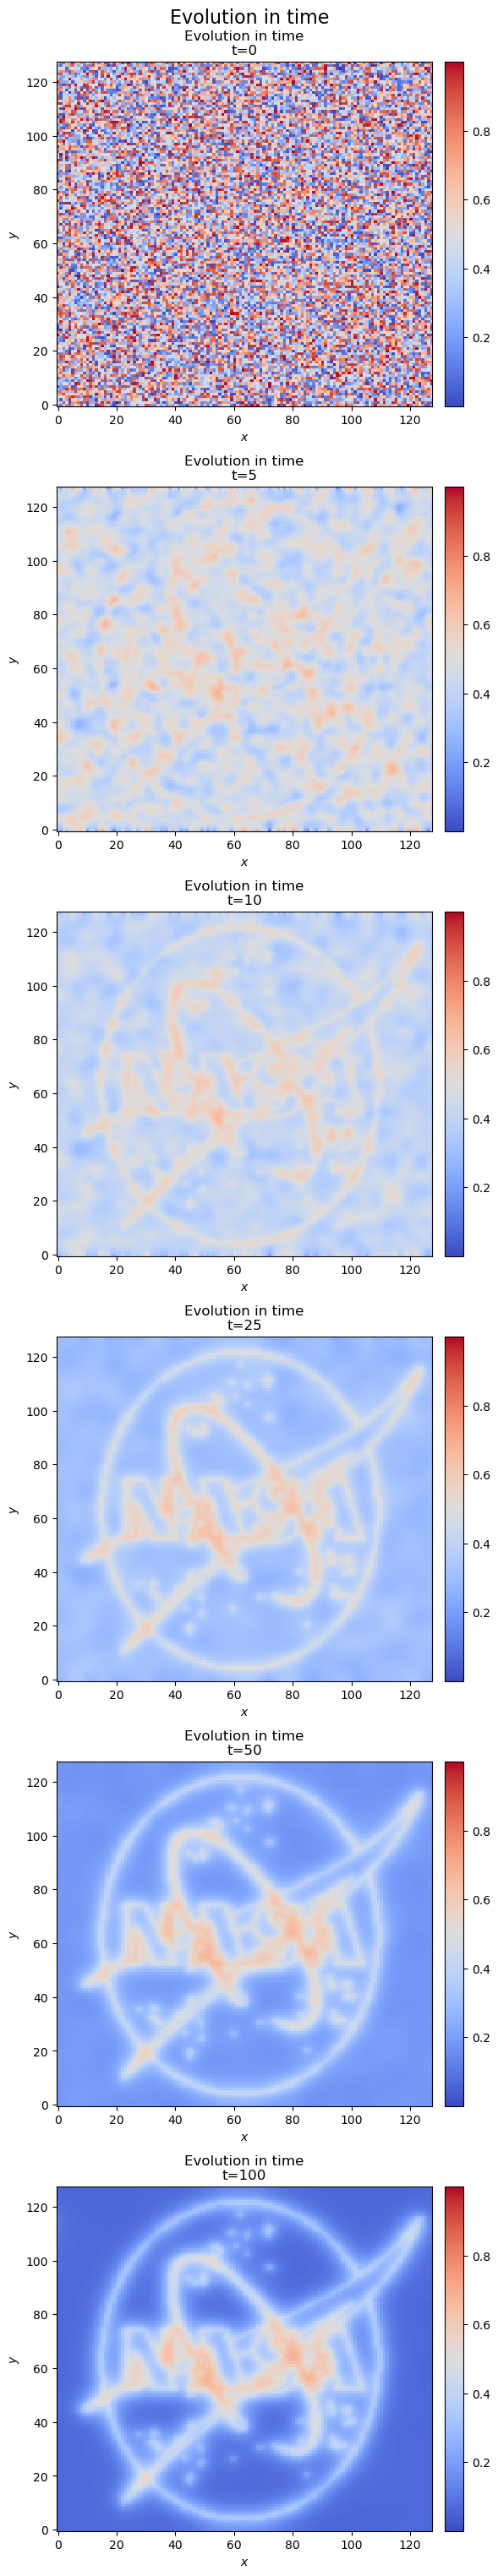

In [5]:
c0 = np.random.rand(nr*nc,1)
saved_timesteps = [0, 5, 10, 25, 50, 100, 250, 500, 1000]
duration = 101

const = F * f.reshape(nr*nc,1)
_, state_over_time = compute_affine_time_evolution(c0, M, const, saved_timesteps, duration)

helper.plot_2d_heatmap_time_evolution(saved_timesteps, state_over_time, nr, nc)